In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
from PIL import Image
import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp012'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [6]:
# waypointを補正したdataset
root_dir = Path('../../input/google-smartphone-decimeter-challenge')
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv', index_col=0)


In [21]:
train = from_pickle("../../input/imu_dataset_v3/train.pkl")
target_df = train[(train["collectionName"]=="2020-05-14-US-MTV-2")&(train["phoneName"]=="Pixel4XLModded")].sort_values("millisSinceGpsEpoch").reset_index(drop=True)
target_df["epoch"] = (target_df["millisSinceGpsEpoch"] - target_df.loc[0, "millisSinceGpsEpoch"])/1000
target_df

,accx_0,accx_1,accx_2,accx_3,accx_4,accx_5,accx_6,accx_7,accx_8,accx_9,...,gyroz_94,gyroz_95,gyroz_96,gyroz_97,gyroz_98,gyroz_99,collectionName,phoneName,millisSinceGpsEpoch,epoch
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-14-US-MTV-2,Pixel4XLModded,1273538835449,0.000
1,-5.615559,-5.666713,-5.631514,-5.583036,-5.560101,-5.545566,-5.631586,-5.749621,-5.868050,-5.878553,...,0.013293,0.022913,0.029499,0.025451,0.006500,-0.013575,2020-05-14-US-MTV-2,Pixel4XLModded,1273538836449,1.000
2,-5.469321,-5.556790,-5.627705,-5.687991,-5.706260,-5.679972,-5.589439,-5.497183,-5.438815,-5.368835,...,-0.012914,-0.030567,-0.046390,-0.060762,-0.066640,-0.068181,2020-05-14-US-MTV-2,Pixel4XLModded,1273538837449,2.000
3,-5.493378,-5.553797,-5.584684,-5.574466,-5.537955,-5.513980,-5.519070,-5.583201,-5.606979,-5.573246,...,0.016427,0.035306,0.056032,0.070925,0.089018,0.108020,2020-05-14-US-MTV-2,Pixel4XLModded,1273538838449,3.000
4,-5.152987,-5.004408,-4.891858,-4.851573,-4.777878,-4.709436,-4.743893,-4.832676,-4.974225,-5.051381,...,-0.019751,-0.015718,-0.007449,-0.003875,-0.010320,-0.025072,2020-05-14-US-MTV-2,Pixel4XLModded,1273538839449,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-14-US-MTV-2,Pixel4XLModded,1273539432643,597.194
573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-14-US-MTV-2,Pixel4XLModded,1273539433633,598.184
574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-14-US-MTV-2,Pixel4XLModded,1273539434646,599.197
575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-14-US-MTV-2,Pixel4XLModded,1273539435643,600.194


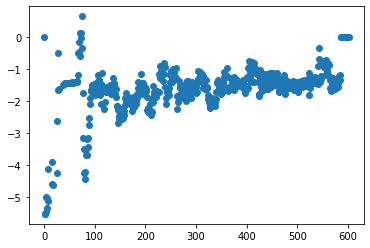

In [22]:
y = target_df.filter(like="accx").fillna(0).mean(axis=1)
x = target_df["epoch"]
plt.scatter(x,y)

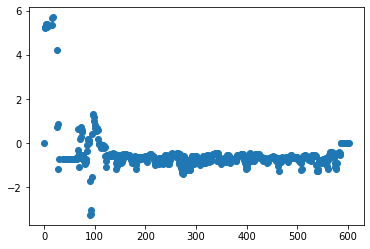

In [23]:
y = target_df.filter(like="accy").fillna(0).mean(axis=1)
x = target_df["epoch"]
plt.scatter(x,y)

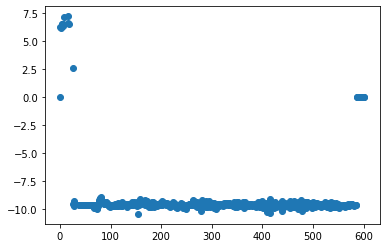

In [24]:
y = target_df.filter(like="accz").fillna(0).mean(axis=1)
x = target_df["epoch"]
plt.scatter(x,y)

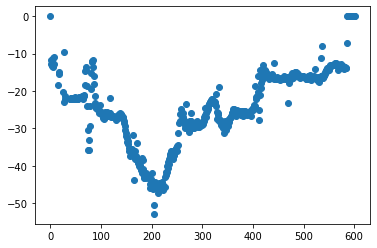

In [25]:
y = target_df.filter(like="magx").fillna(0).mean(axis=1)
x = target_df["epoch"]
plt.scatter(x,y)

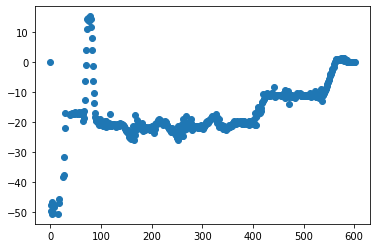

In [26]:
y = target_df.filter(like="magy").fillna(0).mean(axis=1)
x = target_df["epoch"]
plt.scatter(x,y)

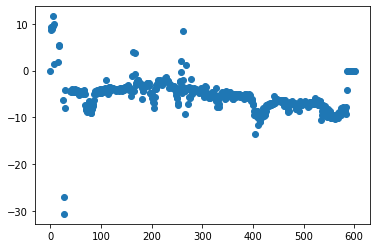

In [27]:
y = target_df.filter(like="magz").fillna(0).mean(axis=1)
x = target_df["epoch"]
plt.scatter(x,y)

In [15]:
test_df = test_df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']]
test_df

,collectionName,phoneName,millisSinceGpsEpoch
0,2020-05-15-US-MTV-1,Pixel4,1273608785432
1,2020-05-15-US-MTV-1,Pixel4,1273608786432
2,2020-05-15-US-MTV-1,Pixel4,1273608787432
3,2020-05-15-US-MTV-1,Pixel4,1273608788432
4,2020-05-15-US-MTV-1,Pixel4,1273608789432
...,...,...,...
91481,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000
91482,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000
91483,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000
91484,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000


## preprocessing

In [16]:
whole_df = pd.concat([train_df, test_df]).reset_index(drop=True)
collection_size = whole_df['collectionName'].nunique()
phone_size = whole_df['phoneName'].nunique()

le_co = LabelEncoder()
le_co.fit(whole_df['collectionName'])
le_ph = LabelEncoder()
le_ph.fit(whole_df['phoneName'])


def preprocess(input_df, le1=le_co, le2=le_ph):
    output_df = input_df.copy()
    
    # LE
    output_df['le_collectionName'] = le1.transform(input_df['collectionName'])
    output_df['le_phoneName'] = le2.transform(input_df['phoneName'])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

In [17]:
train

,collectionName,phoneName,millisSinceGpsEpoch,delta_latDeg,delta_lngDeg,delta_distance,delta_angle,le_collectionName,le_phoneName
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,3.742358e+01,-1.220941e+02,1.277469e+07,-17.041042,0,1
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,2.999982e-10,-1.700002e-09,1.536866e-04,-10.008102,0,1
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,1.040000e-08,3.400004e-09,1.194018e-03,-108.103827,0,1
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,1.140000e-08,1.600000e-09,1.274670e-03,-97.989318,0,1
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,9.900006e-09,-1.600000e-09,1.109164e-03,-80.819484,0,1
...,...,...,...,...,...,...,...,...,...
118233,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,5.000004e-09,0.000000e+00,5.556260e-04,-90.000000,42,6
118234,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,4.999997e-09,0.000000e+00,5.556253e-04,-90.000000,42,6
118235,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,1.700002e-09,-1.600000e-09,2.359524e-04,-46.735758,42,6
118236,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,-4.330000e-08,3.300002e-09,4.820543e-03,94.358216,42,6


In [18]:
test

,collectionName,phoneName,millisSinceGpsEpoch,le_collectionName,le_phoneName
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,2,1
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,2,1
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,2,1
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,2,1
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,2,1
...,...,...,...,...,...
91481,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000,43,6
91482,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000,43,6
91483,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000,43,6
91484,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000,43,6


## model

In [9]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [28]:
imu_path = f'../../input/imu_dataset_v2/train/2020-08-03-US-MTV-1_Pixel4.pkl'
imu_data = from_pickle(imu_path)
imu_data[str(1280525357437)].shape

(9, 100)

In [21]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    
    
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [29]:

# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.delta_criterion = get_criterion(config)
        self.dist_criterion = get_criterion(config)
        self.angle_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, target = batch
        output = self.model(x)
        delta_loss = self.delta_criterion(output[:, [0,1]], target[:, [0,1]])
        dist_loss = self.dist_criterion(output[:, 2], target[:, 2])
        angle_loss = self.angle_criterion(output[:, 3], target[:, 3])
        loss = delta_loss + dist_loss + angle_loss
        return dist_loss
    
    def validation_step(self, batch, batch_idx):
        x, target = batch
        output = self.model(x)
        delta_loss = self.delta_criterion(output[:, [0,1]], target[:, [0,1]])
        dist_loss = self.dist_criterion(output[:, 2], target[:, 2])
        angle_loss = self.angle_criterion(output[:, 3], target[:, 3])
        loss = delta_loss + dist_loss + angle_loss
  
        delta_mse = np.mean((to_np(output[:,0])-to_np(target[:,0]))**2 + (to_np(output[:,1])-to_np(target[:,1]))**2)
        
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'delta/val', delta_mse, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [30]:
def to_np(input):
    return input.detach().cpu().numpy()

# oof
def evaluate(model, loaders, phase):
    lat_list = []
    lng_list = []
    dist_list = []
    angle_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            lat_list.append(to_np(output[:, 0]))
            lng_list.append(to_np(output[:, 1]))
            dist_list.append(to_np(output[:, 2]))
            angle_list.append(to_np(output[:, 3]))
    lat_list = np.concatenate(lat_list)
    lng_list = np.concatenate(lng_list)
    dist_list = np.concatenate(dist_list)
    angle_list = np.concatenate(angle_list)
    return lat_list, lng_list, dist_list, angle_list

In [31]:
# dataset
from torch.utils.data import Dataset, DataLoader
class OutdoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.le_collname_feats = df['le_collectionName'].to_numpy()
        self.le_phonename_feats = df['le_phoneName'].to_numpy()
        self.collname_feats = df['collectionName'].to_numpy()
        self.phonename_feats = df['phoneName'].to_numpy()
        self.epoch_feats = df['millisSinceGpsEpoch'].to_numpy()

        if phase in ['train', 'valid']:
            self.target = df[['delta_latDeg', 'delta_lngDeg', 'delta_distance', 'delta_angle']].values.astype(np.float32)
        
        self.imu_dict = {}
        for (collection_name, phone_name), _ in df.groupby(['collectionName', 'phoneName']):
            if phase in ['train', 'valid']:
                imu_path = f'../../input/imu_dataset_v2/train/{collection_name}_{phone_name}.pkl'
            else:
                imu_path = f'../../input/imu_dataset_v2/test/{collection_name}_{phone_name}.pkl'

            self.imu_dict[f'{collection_name}_{phone_name}'] = from_pickle(imu_path)
            
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
            
        feature = {
            'imu': self.imu_dict[f'{self.collname_feats[idx]}_{self.phonename_feats[idx]}'][str(self.epoch_feats[idx])].astype(np.float32),  # (18, 100)
            'collname':int(self.le_collname_feats[idx]),
            'phonename':int(self.le_phonename_feats[idx]),
        }
        if self.phase in ['train', 'valid']:
            target = self.target[idx]
        else:
            target = None
        return feature, target

In [25]:
class CNNModel(nn.Module):
    def __init__(self, collection_size, phone_size, embedding_dim=16):
        super(CNNModel, self).__init__()
        # imu
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(9, 3)),
            nn.MaxPool2d(1, 3),
            nn.ReLU()
        )
        
        # collection
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(collection_size, embedding_dim),
            nn.Flatten(start_dim=-1)            
        )
        # phone
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(phone_size, embedding_dim),
            nn.Flatten(start_dim=-1)           
        )
        
        feature_size = 33 + embedding_dim*2
        self.fc1 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Linear(feature_size, 512),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc4 = nn.Sequential(
            nn.BatchNorm1d(128),
            nn.Linear(128, 16),
            nn.ReLU()
        )
        self.fc = nn.Linear(16, 4)  # deltaのlat, lng, distance, angle

    
    def forward(self, x):
        # input embedding
        batch_size = x["collname"].shape[0]
        x_imu = self.cnn_layer(x['imu'].unsqueeze(1)).view(batch_size, -1)  # (b,1,18,100)->conv(b,1,1,98)->pool(b,1,1,33)->(b,33)
        x_coll = self.embedding_layer1(x['collname'])
        x_phone = self.embedding_layer2(x['phonename'])
        x = torch.cat([x_imu, x_coll, x_phone], dim=-1)  # (b, 67)

        # MLP
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        # output [batch, 4] delta_lat, delta_lng, distance, angle
        x = self.fc(x).squeeze(1)
        return x

In [26]:
os.makedirs(f'../../model/{EXP_NAME}', exist_ok=True)

## train

In [32]:

oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# gkf = model_selection.GroupKFold(n_splits=N_SPLITS)

train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in skf.split(train, train.loc[:, 'collectionName'])]
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_df = train.loc[trn_idx_for_train, :].reset_index(drop=True)
    val_df = train.loc[val_idx_for_train, :].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(OutdoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(OutdoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(OutdoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = CNNModel(collection_size, phone_size) 
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=5,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='outdoor', entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config['model_name'] = model_name
    wandb_config['comment'] = NOTES
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            # progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval() 
    oof_df = train.loc[val_idx_for_train, :].reset_index(drop=True)
    oof_x, oof_y, oof_d, oof_a = evaluate(model, loaders, phase="valid")
    oof_df["oof_delta_latDeg"] = oof_x
    oof_df["oof_delta_lngDeg"] = oof_y
    oof_df['oof_delta_distance'] = oof_d
    oof_df['oof_delta_angle'] = oof_a
    oofs.append(oof_df)
    
    val_score = np.mean(calc_haversine(oof_df['oof_delta_latDeg'], oof_df['oof_delta_lngDeg'], 
                                       oof_df['delta_latDeg'], oof_df['delta_lngDeg']))
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, _, _ = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    # test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)

    if fold != 4:
        wandb.finish()

Fold 0


Loss/val,89381830656.0
delta/val,1330056.625
epoch,8
trainer/global_step,1664
_runtime,22
_timestamp,1622533281
_step,8


Loss/val,█▆▃▁█▇▅▆▇
delta/val,▂▃▃▄▁▁▂▁█
epoch,▁▂▃▄▅▅▆▇█
trainer/global_step,▁▂▃▄▅▅▆▇█
_runtime,▁▂▃▄▅▆▆▇█
_timestamp,▁▂▃▄▅▆▆▇█
_step,▁▂▃▄▅▅▆▇█


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True

  | Name            | Type     | Params
---------------------------------------------
0 | model           | CNNModel | 202 K 
1 | delta_criterion | MSELoss  | 0     
2 | dist_criterion  | MSELoss  | 0     
3 | angle_criterion | MSELoss  | 0     
---------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.812     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

RuntimeError: max must be larger than min

## validation

In [ ]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
# oofs_df.to_csv("oof.csv", index=False)
oofs_df

In [ ]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

In [ ]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    # all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
    all_preds = pd.concat(predictions).reset_index().groupby('index').mean()
    all_preds['site_path_timestamp'] = predictions[0]['site_path_timestamp'].values
else:
    all_preds = predictions[0]

In [ ]:
sub.to_csv(EXP_NAME + '_sub.csv')